# CNN Pytorch - Intel Image Classification

## Description

### Description of Kaggle objectives

This notebook contains the code used for the Intel Image Classification dataset (link: https://www.kaggle.com/datasets/puneet6060/intel-image-classification). 

The following description is taken from the Kaggle website:

*Context: This is image data of Natural Scenes around the world.*

*Inspiration: Want to build powerful Neural network that can classify these images with more accuracy.*

### Description of  Dataset

The following description of the dataset is taken from the Kaggle website:

*Content*

*This Data contains around 25k images of size 150x150 distributed under 6 categories.*
*{'buildings' -> 0,*
*'forest' -> 1,*
*'glacier' -> 2,*
*'mountain' -> 3,*
*'sea' -> 4,*
*'street' -> 5 }*

*The Train, Test and Prediction data is separated in each zip files. There are around 14k images in Train, 3k in Test and 7k in Prediction.*


## Import Libaries

In [45]:
import os 

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Prepare Training, Validation, and Test Datasets

Specifically, create csv file containing the filepath and labels of images in the training, validation, and test sets. 

In [72]:
# Create dictionary for image categories
dict_ctg = {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}

# Define function to create data labels
def create_labels(pth):
    labels = pd.DataFrame(columns = ['filepath', 'id', 'label'])
    
    for ctg in dict_ctg:
        filePath = os.path.join(pth, ctg)
        fileNames = [f for f in os.listdir(filePath) if os.path.isfile(os.path.join(os.getcwd(), filePath, f))]
        labels = pd.concat([labels, 
                            pd.DataFrame({'filepath': [ filePath ] * len(fileNames),  
                                          'id': fileNames, 
                                          'label': [ dict_ctg[ctg] ]  * len(fileNames),
                                          'category': [ctg] * len(fileNames) })],
                            axis = 0)
    
    labels['filename'] = labels['filepath'] + '\\' + labels['id']
    return labels

# Load data labels; create data labels if necessary
if os.path.exists('train_labels.csv'):
    train_labels = pd.read_csv('train_labels.csv')
else:
    train_labels = create_labels(pth = os.path.join('seg_train', 'seg_train') )
    train_labels.to_csv('train_labels.csv', sep = '\t')
if os.path.exists('test_labels.csv'):
    test_labels = pd.read_csv('test_labels.csv')
else:
    test_labels = create_labels(pth = os.path.join('seg_test', 'seg_test') )
    test_labels.to_csv('test_labels.csv', sep = '\t')

Let's take a look at the format of the label dataframe.

In [73]:
train_labels.head()

,filepath,id,label,category,filename
0,seg_train\seg_train\buildings,0.jpg,0,buildings,seg_train\seg_train\buildings\0.jpg
1,seg_train\seg_train\buildings,10006.jpg,0,buildings,seg_train\seg_train\buildings\10006.jpg
2,seg_train\seg_train\buildings,1001.jpg,0,buildings,seg_train\seg_train\buildings\1001.jpg
3,seg_train\seg_train\buildings,10014.jpg,0,buildings,seg_train\seg_train\buildings\10014.jpg
4,seg_train\seg_train\buildings,10018.jpg,0,buildings,seg_train\seg_train\buildings\10018.jpg


Now, let's split the training set into a training and validation set.

In [133]:
#  Dividing training data into training and validation sets
train_df, val_df = train_test_split(train_labels, test_size = 0.2, random_state = 42, stratify = train_labels['label'])

# Convert labels to strings
train_df['label'] = train_df['label'].astype(str)
val_df['label'] = val_df['label'].astype(str)

# Explore training and validation set size
print(f"Size of training set: {len(train_df)}")
print(f"Size of validation set: {len(val_df)}")

# Explore test set size
test_df = test_labels
test_df['label'] = test_df['label'].astype(str)
print(f"Size of test set: {len(test_df)}")

Size of training set: 11227
Size of validation set: 2807
Size of test set: 3000


## Exploratory Data Analysis

Explore the frequency of labels in the training and validation set

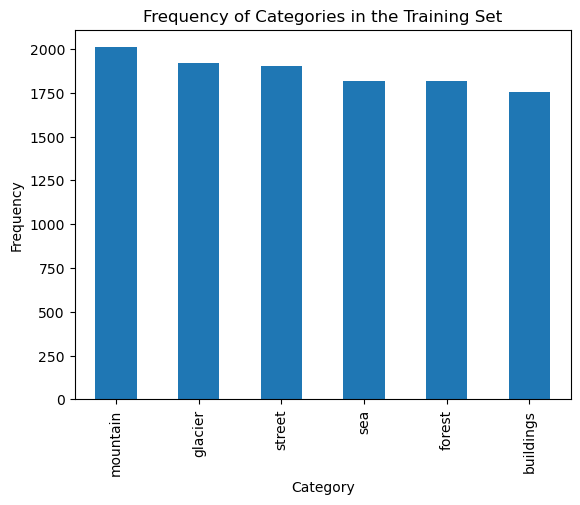

category
mountain     2009
glacier      1923
street       1906
sea          1819
forest       1817
buildings    1753
Name: count, dtype: int64


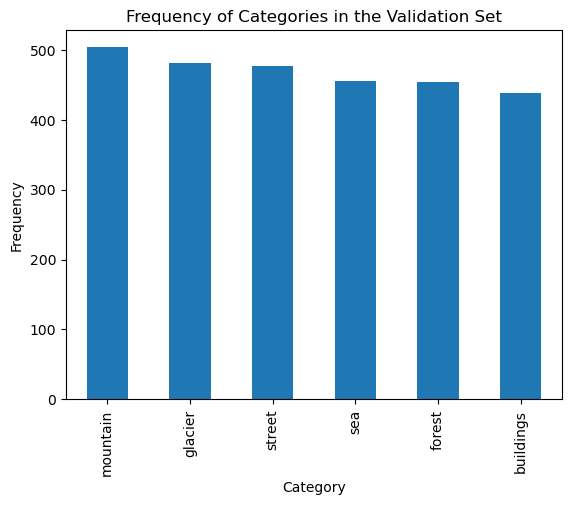

category
mountain     503
glacier      481
street       476
sea          455
forest       454
buildings    438
Name: count, dtype: int64


In [134]:
# Training set
train_df['category'].value_counts().plot(kind='bar')
plt.title('Frequency of Categories in the Training Set')
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.show()
print(train_df['category'].value_counts())

# Validation set
val_df['category'].value_counts().plot(kind='bar')
plt.title('Frequency of Categories in the Validation Set')
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.show()
print(val_df['category'].value_counts())

Looks like there is a good mix of image categories in both the training and validation sets.

Next, let's examine a few images from each category in the training and validation sets.

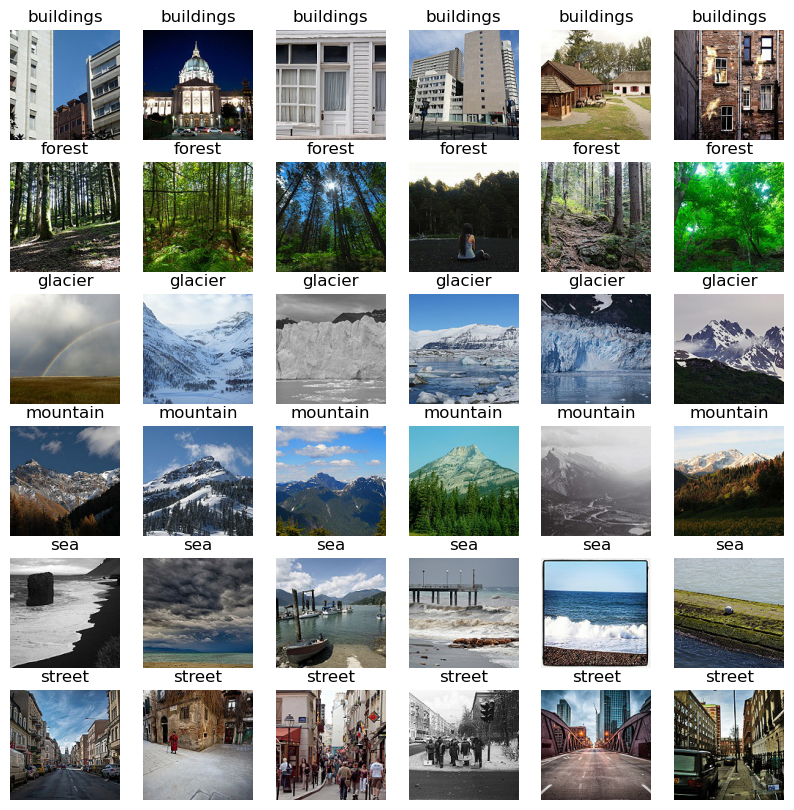

In [135]:
plt.figure( figsize = (10, 10) )
cnt = 1
for ctg in dict_ctg:
    for i in range(6):
        image = train_df.loc[train_df['category'] == ctg]['filename'].iloc[i]
        image_open = Image.open(os.path.join(os.getcwd(), image))
        
        ax = plt.subplot(6, 6, cnt)
        plt.imshow(image_open)
        plt.title(ctg)
        plt.axis('off')
        cnt += 1

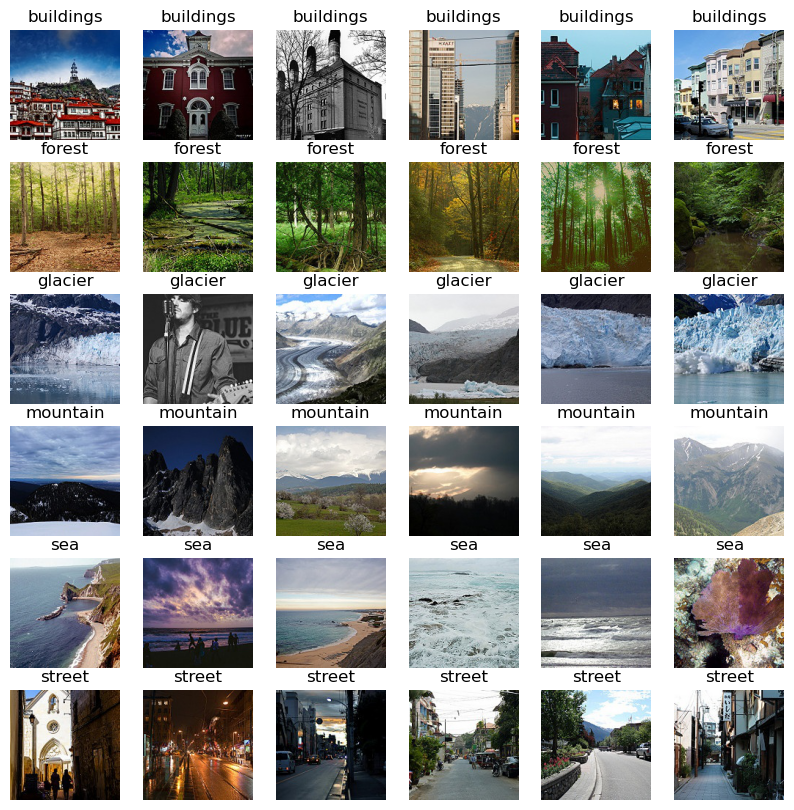

In [136]:
plt.figure( figsize = (10, 10) )
cnt = 1
for ctg in dict_ctg:
    for i in range(6):
        image = val_df.loc[val_df['category'] == ctg]['filename'].iloc[i]
        image_open = Image.open(os.path.join(os.getcwd(), image))
        
        ax = plt.subplot(6, 6, cnt)
        plt.imshow(image_open)
        plt.title(ctg)
        plt.axis('off')
        cnt += 1

## Model Architecture

For this project, we will use Convolutional Neural Networks (CNN) due to their effectiveneses for image classfication.

To begin, we will create the following models:
- 1) Baseline model
- 2) More layers model
- 3) More layers with dropout model

The hypothesis is that the 3rd model will outperform as adding more neurons/layers will enable the model to pick up more complex features and adding dropout will prevent overfitting.

In [137]:
def create_baseline_model():
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(96, 96, 3)),
        MaxPooling2D(2,2),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(6, activation='softmax')
    ])
    return model

baseline_model = create_baseline_model()
baseline_model.summary()

C:\Users\steph\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_64 (Conv2D)                   │ (None, 94, 94, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_48 (MaxPooling2D)      │ (None, 47, 47, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_65 (Conv2D)                   │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_49 (MaxPooling2D)      │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_24 (Flatten)                 │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_48 (Dense)                     │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_49 (Dense)                     │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,985,222 (15.20 MB)

 Trainable params: 3,985,222 (15.20 MB)

 Non-trainable params: 0 (0.00 B)

In [138]:
def create_layers_model():
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(96, 96, 3)),
        MaxPooling2D(2,2),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Conv2D(128, (3,3), activation='relu'),
        Flatten(),
        Dense(256, activation='relu'),
        Dense(6, activation='softmax')
    ])
    return model

layers_model = create_layers_model()
layers_model.summary()

Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_66 (Conv2D)                   │ (None, 94, 94, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_50 (MaxPooling2D)      │ (None, 47, 47, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_67 (Conv2D)                   │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_51 (MaxPooling2D)      │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_68 (Conv2D)                   │ (None, 20, 20, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_25 (Flatten)                 │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_50 (Dense)                     │ (None, 256)                 │      13,107,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_51 (Dense)                     │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,202,246 (50.36 MB)

 Trainable params: 13,202,246 (50.36 MB)

 Non-trainable params: 0 (0.00 B)

In [139]:
def create_layers_dropout_model():
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(96, 96, 3)),
        MaxPooling2D(2,2),
        Dropout(0.2),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Dropout(0.2),
        Conv2D(128, (3,3), activation='relu'),
        Flatten(),
        Dropout(0.2),
        Dense(256, activation='relu'),
        Dropout(0.2),
        Dense(6, activation='softmax')
    ])
    return model

layers_dropout_model = create_layers_dropout_model()
layers_dropout_model.summary()

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_69 (Conv2D)                   │ (None, 94, 94, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_52 (MaxPooling2D)      │ (None, 47, 47, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_32 (Dropout)                 │ (None, 47, 47, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_70 (Conv2D)                   │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_53 (MaxPooling2D)      │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_33 (Dropout)                 │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_71 (Conv2D)                   │ (None, 20, 20, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_26 (Flatten)                 │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_34 (Dropout)                 │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_52 (Dense)                     │ (None, 256)                 │      13,107,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_35 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_53 (Dense)                     │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,202,246 (50.36 MB)

 Trainable params: 13,202,246 (50.36 MB)

 Non-trainable params: 0 (0.00 B)

## Data Preprocessing

First, let's create the data generators.

In [140]:
# Create image data generators
train_datagen = ImageDataGenerator(rescale = 1./255, horizontal_flip = True, vertical_flip = True)
val_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe = train_df,
    directory = os.getcwd(),
    x_col = 'filename',
    y_col = 'label',
    target_size = (96, 96),
    batch_size = 32,
    class_mode = 'categorical'
)
val_generator = val_datagen.flow_from_dataframe(
    dataframe = val_df,
    directory = os.getcwd(),
    x_col = 'filename',
    y_col = 'label',
    target_size = (96, 96),
    batch_size = 32,
    class_mode = 'categorical'
)

Found 11227 validated image filenames belonging to 6 classes.
Found 2807 validated image filenames belonging to 6 classes.


## Compile Models

In this step, we compile the three models described above. Accuracy will be used as the metric of itnerest to assess model performance.

In [143]:
# Compile models
baseline_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
layers_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
layers_dropout_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## Model Training

In this step, we will train the three models described above. We'll use 10 epochs in order to balance improvements in model performance from training vs. training time.

In [144]:
# Train model
baseline_model_train = baseline_model.fit(
    train_generator,
    epochs = 10,
    validation_data = val_generator
)

# Save model
baseline_model.save("baseline_model.keras")

Epoch 1/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 86s 238ms/step - accuracy: 0.4649 - loss: 1.4025 - val_accuracy: 0.6715 - val_loss: 0.8833
Epoch 2/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 84s 238ms/step - accuracy: 0.6783 - loss: 0.8494 - val_accuracy: 0.6665 - val_loss: 0.8655
Epoch 3/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 77s 220ms/step - accuracy: 0.7212 - loss: 0.7371 - val_accuracy: 0.7111 - val_loss: 0.7786
Epoch 4/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 70s 198ms/step - accuracy: 0.7687 - loss: 0.6443 - val_accuracy: 0.7439 - val_loss: 0.6954
Epoch 5/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 70s 199ms/step - accuracy: 0.7797 - loss: 0.5976 - val_accuracy: 0.7214 - val_loss: 0.7362
Epoch 6/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 70s 200ms/step - accuracy: 0.8127 - loss: 0.5219 - val_accuracy: 0.7941 - val_loss: 0.6021
Epoch 7/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 72s 205ms/step - accuracy: 0.8285 - loss: 0.4812 - val_accuracy: 0.7713 - val_loss: 0.6675
Epoch 8/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 73s 208ms/step - accuracy: 0.8466 - loss: 0

In [146]:
# Train model
layers_model_train = layers_model.fit(
    train_generator,
    epochs = 10,
    validation_data = val_generator
)

# Save model
layers_model.save("layers_model.keras")

Epoch 1/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 134s 375ms/step - accuracy: 0.4333 - loss: 1.4717 - val_accuracy: 0.6192 - val_loss: 0.9575
Epoch 2/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 121s 343ms/step - accuracy: 0.6545 - loss: 0.9045 - val_accuracy: 0.6915 - val_loss: 0.8087
Epoch 3/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 122s 348ms/step - accuracy: 0.7264 - loss: 0.7278 - val_accuracy: 0.7553 - val_loss: 0.6689
Epoch 4/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 121s 344ms/step - accuracy: 0.7653 - loss: 0.6341 - val_accuracy: 0.7613 - val_loss: 0.6675
Epoch 5/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 125s 356ms/step - accuracy: 0.7836 - loss: 0.5977 - val_accuracy: 0.7887 - val_loss: 0.6001
Epoch 6/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 123s 350ms/step - accuracy: 0.8096 - loss: 0.5168 - val_accuracy: 0.7927 - val_loss: 0.6001
Epoch 7/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 120s 343ms/step - accuracy: 0.8297 - loss: 0.4589 - val_accuracy: 0.8051 - val_loss: 0.5516
Epoch 8/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 123s 350ms/step - accuracy: 0.8577 -

In [147]:
# Train model
layers_droupout_model_train = layers_dropout_model.fit(
    train_generator,
    epochs = 10,
    validation_data = val_generator
)

# Save model
layers_dropout_model.save("layers_dropout_model.keras")

Epoch 1/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 133s 372ms/step - accuracy: 0.4277 - loss: 1.4116 - val_accuracy: 0.5853 - val_loss: 1.0657
Epoch 2/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 130s 371ms/step - accuracy: 0.6480 - loss: 0.8938 - val_accuracy: 0.6929 - val_loss: 0.7923
Epoch 3/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 131s 374ms/step - accuracy: 0.7161 - loss: 0.7626 - val_accuracy: 0.6509 - val_loss: 0.9488
Epoch 4/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 139s 396ms/step - accuracy: 0.7545 - loss: 0.6741 - val_accuracy: 0.7535 - val_loss: 0.6715
Epoch 5/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 149s 425ms/step - accuracy: 0.7645 - loss: 0.6363 - val_accuracy: 0.7788 - val_loss: 0.6048
Epoch 6/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 134s 381ms/step - accuracy: 0.7845 - loss: 0.5829 - val_accuracy: 0.7663 - val_loss: 0.6587
Epoch 7/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 140s 397ms/step - accuracy: 0.7962 - loss: 0.5482 - val_accuracy: 0.7795 - val_loss: 0.6222
Epoch 8/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 136s 386ms/step - accuracy: 0.8033 -

## Model Evaluation

Let's evaluate the performane of the three models. We'll use some data visualizations to plot the accuracy over each epoch of the respective models in the training and validation sets.

In [148]:
def create_plot(trained_model, title):
    plt.figure(figsize = (12, 4))
    plt.plot(trained_model.history['accuracy'], label='Training Set')
    plt.plot(trained_model.history['val_accuracy'], label='Validation Set')
    plt.title(f'{title} - Accuracy')
    plt.legend()
    plt.show()

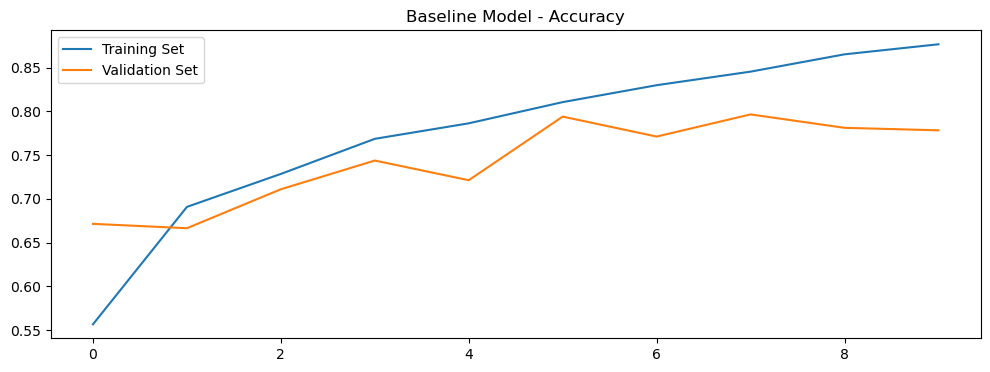

In [149]:
create_plot(baseline_model_train, 'Baseline Model')

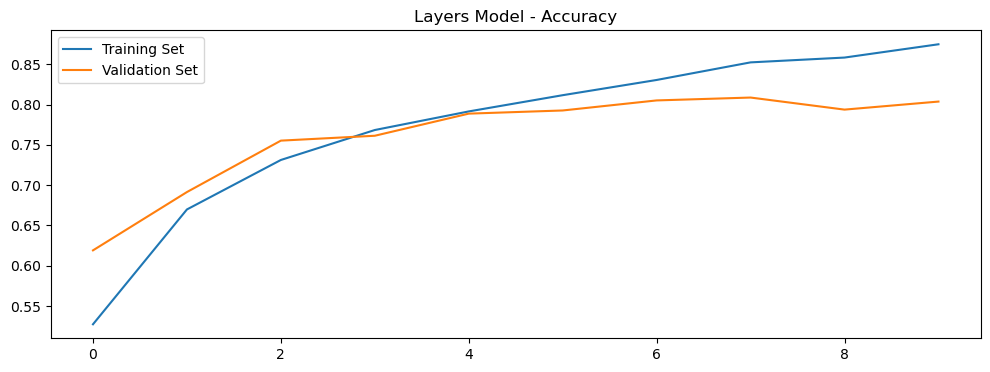

In [150]:
create_plot(layers_model_train, 'Layers Model')

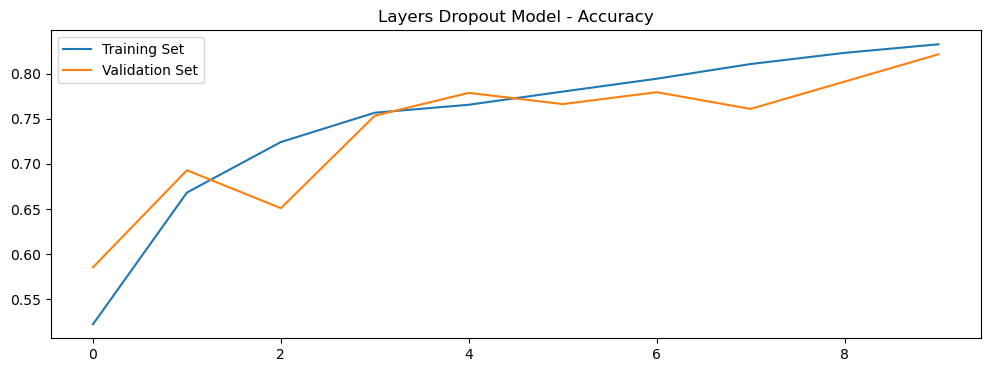

In [151]:
create_plot(layers_droupout_model_train, 'Layers Dropout Model')

A few observations about the accuracy of the 3 models in the training and validation sets:
- The accuracy of the model in the training set was highest in the baseline / layers model
- The accuracy of the model in the validation set was highest in the layers with dropout model; and the layers model had improved accuracy in the validation set compared to the baseline model

These findings are in-line with expectations. The addition of layers/neurons improves accuracy by allowing the omdel to pick up on more complex associations. Meanwhile, adding dropout leads to improved accuracy in the validation set while preventing overfitting in the training set.

## Hyperparemeter Tuning

Next, we will take a deeper dive into hyperparameter tuning.

Our evaluation of the 3 aforementioned models has already yielded quite a few insights with regards to hyperparameter tuning:
- Number of layers/neurons: Increasing the number of layers/neurons improves the ability of the model to detect complex associations
- Number of epochs: Increasing the number of epochs during training generally improves the performance of the model
- Dropout: Adding dropout to the model improved the accuracy of the model in the validation set by reducing overfitting. In fact, the accuracy in the training and validation sets was quite similar in this case.

Next, we'll test the impact of the following hyperparameters
- Changing the batch size (16 vs. 32 (default) vs. 64)
- Changing the learning rate (0.001 (default) vs. 0.05 vs. 0.5)

Note, hyperparameter tuning is being performed to explore, descriptively, the impact of modifying the hyperparameters. For these purposes, we will use a lower number of epochs (5), which should be sufficient to explore the impact of modifying the hyperparameters.

First, let's explore the impact of changing the batch size.

In [158]:
# Create models
layers_dropout_model2 = create_layers_dropout_model()
layers_dropout_model3 = create_layers_dropout_model()

# Data generators with batch size of 16
train_generator_16 = train_datagen.flow_from_dataframe(
    dataframe = train_df,
    directory = os.getcwd(),
    x_col = 'filename',
    y_col = 'label',
    target_size = (96, 96),
    batch_size = 16,
    class_mode = 'categorical'
)
val_generator_16 = val_datagen.flow_from_dataframe(
    dataframe = val_df,
    directory = os.getcwd(),
    x_col = 'filename',
    y_col = 'label',
    target_size = (96, 96),
    batch_size = 16,
    class_mode = 'categorical'
)

# Data generators with batch size of 64
train_generator_64 = train_datagen.flow_from_dataframe(
    dataframe = train_df,
    directory = os.getcwd(),
    x_col = 'filename',
    y_col = 'label',
    target_size = (96, 96),
    batch_size = 64,
    class_mode = 'categorical'
)
val_generator_64 = val_datagen.flow_from_dataframe(
    dataframe = val_df,
    directory = os.getcwd(),
    x_col = 'filename',
    y_col = 'label',
    target_size = (96, 96),
    batch_size = 64,
    class_mode = 'categorical'
)

# Compile models
layers_dropout_model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
layers_dropout_model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

C:\Users\steph\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Found 11227 validated image filenames belonging to 6 classes.
Found 2807 validated image filenames belonging to 6 classes.
Found 11227 validated image filenames belonging to 6 classes.
Found 2807 validated image filenames belonging to 6 classes.


In [159]:
# Model with dropout with a batch size of 16
layers_droupout_model_train_16 = layers_dropout_model2.fit(
    train_generator_16,
    epochs = 5,
    validation_data = val_generator_16
)

Epoch 1/5


C:\Users\steph\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


702/702 ━━━━━━━━━━━━━━━━━━━━ 192s 270ms/step - accuracy: 0.3770 - loss: 1.4915 - val_accuracy: 0.6003 - val_loss: 0.9905
Epoch 2/5
702/702 ━━━━━━━━━━━━━━━━━━━━ 189s 269ms/step - accuracy: 0.6216 - loss: 0.9587 - val_accuracy: 0.6648 - val_loss: 0.9067
Epoch 3/5
702/702 ━━━━━━━━━━━━━━━━━━━━ 188s 267ms/step - accuracy: 0.7063 - loss: 0.7792 - val_accuracy: 0.7253 - val_loss: 0.7280
Epoch 4/5
702/702 ━━━━━━━━━━━━━━━━━━━━ 186s 265ms/step - accuracy: 0.7369 - loss: 0.6962 - val_accuracy: 0.7570 - val_loss: 0.6592
Epoch 5/5
702/702 ━━━━━━━━━━━━━━━━━━━━ 185s 264ms/step - accuracy: 0.7629 - loss: 0.6316 - val_accuracy: 0.7410 - val_loss: 0.7179


In [160]:
# Model with dropout with a batch size of 64
layers_dropout_model_train_64 = layers_dropout_model3.fit(
    train_generator_64,
    epochs = 5,
    validation_data = val_generator_64
)

Epoch 1/5
176/176 ━━━━━━━━━━━━━━━━━━━━ 107s 598ms/step - accuracy: 0.3490 - loss: 1.7078 - val_accuracy: 0.5810 - val_loss: 1.0689
Epoch 2/5
176/176 ━━━━━━━━━━━━━━━━━━━━ 106s 603ms/step - accuracy: 0.5899 - loss: 1.0285 - val_accuracy: 0.6231 - val_loss: 0.9311
Epoch 3/5
176/176 ━━━━━━━━━━━━━━━━━━━━ 106s 603ms/step - accuracy: 0.6531 - loss: 0.8932 - val_accuracy: 0.6819 - val_loss: 0.8136
Epoch 4/5
176/176 ━━━━━━━━━━━━━━━━━━━━ 110s 624ms/step - accuracy: 0.7057 - loss: 0.7754 - val_accuracy: 0.7410 - val_loss: 0.7075
Epoch 5/5
176/176 ━━━━━━━━━━━━━━━━━━━━ 108s 611ms/step - accuracy: 0.7409 - loss: 0.6962 - val_accuracy: 0.7410 - val_loss: 0.6922


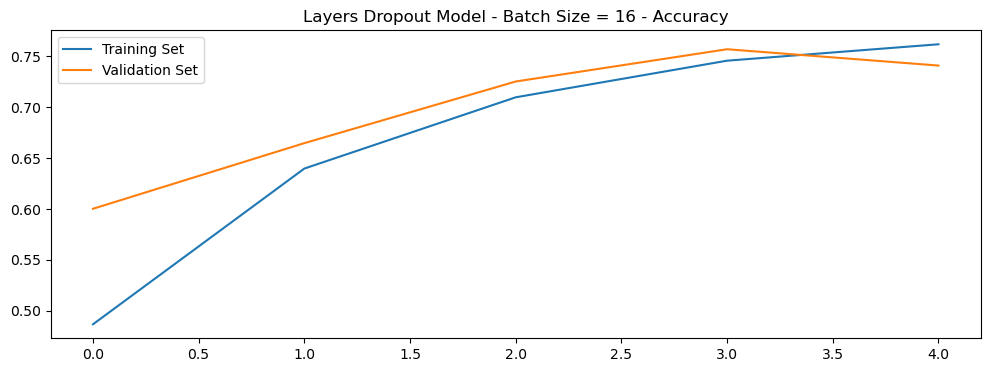

In [161]:
create_plot(layers_droupout_model_train_16, 'Layers Dropout Model - Batch Size = 16')

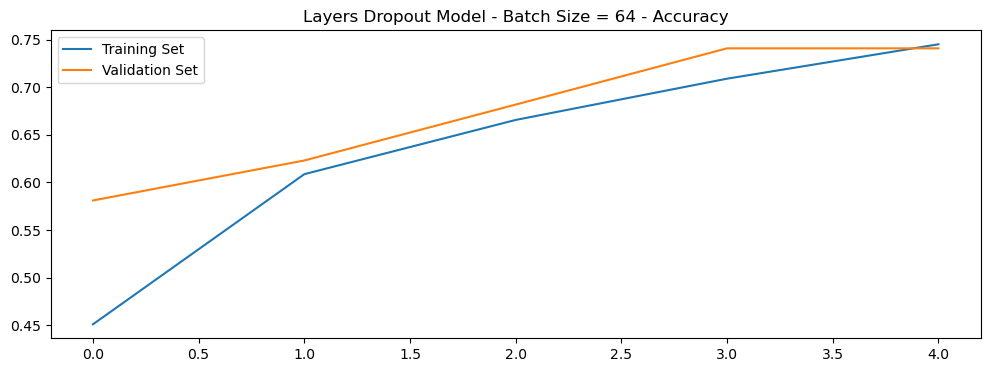

In [162]:
create_plot(layers_dropout_model_train_64, 'Layers Dropout Model - Batch Size = 64')

The larger batch size (64) trained faster, but the accuracy in the validation set was comparable regardless of whether the batch size was 16 or 64. That being said, the batch size of 32 had better accuracy in the training/validation sets after 5 epochs as comapred to a batch size of either 16 or 64.

Next, let's explore the impact of tuning the learning rate (0.05 vs. 0.5).

In [163]:
# Create optimizers
optimizer_05 = tf.keras.optimizers.Adam(learning_rate = 0.05)
optimizer_5 = tf.keras.optimizers.Adam(learning_rate = 0.5)

# Create models -- same as prior but we will change learning rate during compiling
layers_dropout_model_lr05 = create_layers_dropout_model()
layers_dropout_model_lr5 = create_layers_dropout_model()

# Compile models
layers_dropout_model_lr05.compile(optimizer=optimizer_05, loss='categorical_crossentropy', metrics=['accuracy'])
layers_dropout_model_lr5.compile(optimizer=optimizer_5, loss='categorical_crossentropy', metrics=['accuracy'])

C:\Users\steph\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [164]:
# Fit model with learning rate of 0.5
layers_dropout_model_lr05_train = layers_dropout_model_lr05.fit(
    train_generator,
    epochs = 5,
    validation_data = val_generator
)

Epoch 1/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 150s 407ms/step - accuracy: 0.1662 - loss: 317.7434 - val_accuracy: 0.1560 - val_loss: 1.7951
Epoch 2/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 133s 380ms/step - accuracy: 0.1600 - loss: 1.7951 - val_accuracy: 0.1714 - val_loss: 1.7960
Epoch 3/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 137s 392ms/step - accuracy: 0.1723 - loss: 1.7947 - val_accuracy: 0.1792 - val_loss: 1.7941
Epoch 4/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 134s 381ms/step - accuracy: 0.1676 - loss: 1.7959 - val_accuracy: 0.1621 - val_loss: 1.7960
Epoch 5/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 129s 368ms/step - accuracy: 0.1673 - loss: 1.7974 - val_accuracy: 0.1792 - val_loss: 1.7930


In [165]:
# Fit model with learning rate of 5
layers_dropout_model_lr5_train = layers_dropout_model_lr5.fit(
    train_generator,
    epochs = 5,
    validation_data = val_generator
)

Epoch 1/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 132s 370ms/step - accuracy: 0.1705 - loss: 21429966.0000 - val_accuracy: 0.1696 - val_loss: 1.8161
Epoch 2/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 131s 374ms/step - accuracy: 0.1693 - loss: 1.8246 - val_accuracy: 0.1621 - val_loss: 1.8185
Epoch 3/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 136s 386ms/step - accuracy: 0.1686 - loss: 1.8239 - val_accuracy: 0.1617 - val_loss: 1.8266
Epoch 4/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 133s 378ms/step - accuracy: 0.1724 - loss: 1.8325 - val_accuracy: 0.1621 - val_loss: 1.8050
Epoch 5/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 130s 369ms/step - accuracy: 0.1576 - loss: 1.8344 - val_accuracy: 0.1621 - val_loss: 1.8152


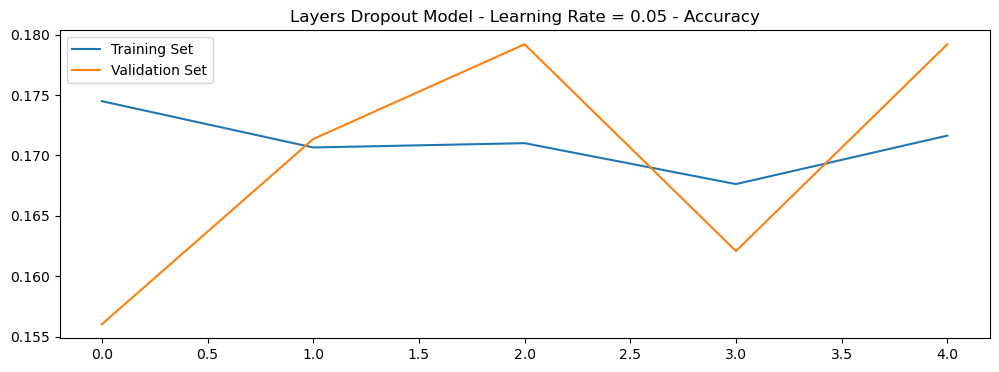

In [168]:
create_plot(layers_dropout_model_lr05_train, 'Layers Dropout Model - Learning Rate = 0.05')

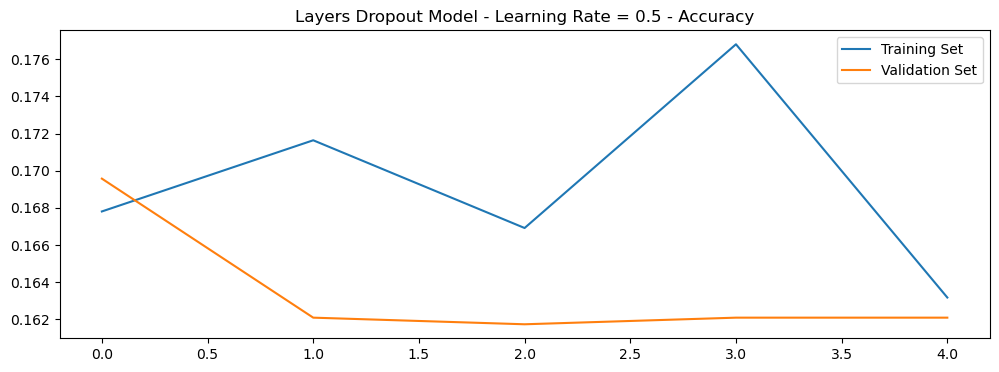

In [169]:
create_plot(layers_dropout_model_lr5_train, 'Layers Dropout Model - Learning Rate = 0.5')

A significant deterioration in the accuracy of the models in both the training and validation sets was observed when increasing the learning rate to either 0.05 or 0.50. Moreover, the model performance did not appear to improve over each of the 5 epochs.

## Applying Model to Test Set

Now, we will apply the "layers_dropout_model" to the test set. We selected this model as it had the best performance (i.e., accuracy) in the validation set.

In [171]:
# Load model
layers_dropout_model = tf.keras.models.load_model('layers_dropout_model.keras')

In [173]:
# Create generator for test data
test_datagen = ImageDataGenerator(rescale = 1./255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe = test_df,
    directory = os.getcwd(),
    x_col = 'filename',
    y_col = 'label',
    target_size = (96, 96),
    batch_size = 1,
    class_mode = 'categorical',
    shuffle = False
)

Found 3000 validated image filenames belonging to 6 classes.


In [174]:
# Predict labels using model
test_generator.reset()
pred = layers_dropout_model.predict(test_generator, verbose = 1)

C:\Users\steph\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3000/3000 ━━━━━━━━━━━━━━━━━━━━ 31s 10ms/step


In [186]:
# Create inverse dictionary
def inverse_mapping(f):
    return f.__class__(map(reversed, f.items()))
dict_ctg_inv = inverse_mapping(dict_ctg)

# Append prediction to data frame
pred_df = test_df
pred_df['label'] = pred_df['label'].astype(int)
pred_df['pred'] = np.argmax(pred, axis=1)
pred_df['pred_category'] = pred_df['pred'].map(dict_ctg_inv)

# View data frame
pred_df.head()

,filepath,id,label,category,filename,pred,pred_category
0,seg_test\seg_test\buildings,20057.jpg,0,buildings,seg_test\seg_test\buildings\20057.jpg,0,buildings
1,seg_test\seg_test\buildings,20060.jpg,0,buildings,seg_test\seg_test\buildings\20060.jpg,0,buildings
2,seg_test\seg_test\buildings,20061.jpg,0,buildings,seg_test\seg_test\buildings\20061.jpg,0,buildings
3,seg_test\seg_test\buildings,20064.jpg,0,buildings,seg_test\seg_test\buildings\20064.jpg,0,buildings
4,seg_test\seg_test\buildings,20073.jpg,0,buildings,seg_test\seg_test\buildings\20073.jpg,4,sea


<Axes: >

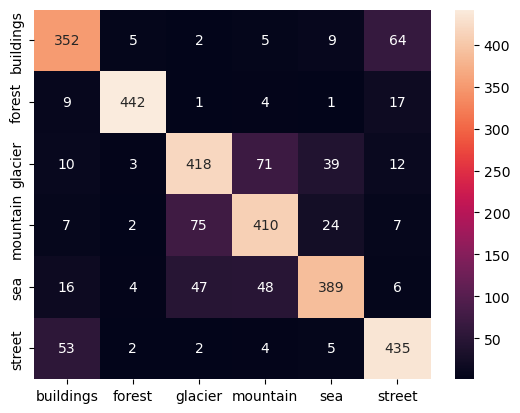

In [197]:
# Plot heatmap
cm = confusion_matrix(pred_df['category'], pred_df['pred_category'])
class_labels = list(dict_ctg)
sns.heatmap(cm, annot=True, xticklabels=class_labels, yticklabels=class_labels, fmt=".0f")

In [207]:
print('The overall accuracy in the test set is: ', cm.diagonal().sum()/cm.sum())
print("")
print("The accuracy of the following categories in the test set was: ")
print(f"  {class_labels}")
print(f"  {cm.diagonal()/cm.sum(axis=1)}")

The overall accuracy in the test set is:  0.8153333333333334

The accuracy of the following categories in the test set was: 
  ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
  [0.80549199 0.93248945 0.75587703 0.78095238 0.7627451  0.86826347]


We have applied our model to the test set and found the the accuracy of the model is approxiamtely 81.5%. As expected, this is similar to the performance of the model in the validation set. Looks like our model performed well at classifying forests (acc=93%) and streets (acc=87%). The accuracy was lower, albeit still >75% for each of the other categories.

There was some error in distinguishing between buildings and streets, and in distinguishing between glaciers, mountains, and the sea. Indeed, pictures of streets may contain buildings and similarities in the colors/shapes of glaciers, mountains and the sea could lead to misclassification.

## Conclusion

In this project, we trained a CNN to classify images into one of 6 categories: buildings, forests, glaciers, mountains, seas, and streets. We found that training a network with more layers and neurons was able to detect more complex associations and, therefore, perform better. Furthermore, adding a dropout layer helped to prevent overfitting. The model achieved high accuracy in the test set (81.5%) and performed especially well in categorizing forests (>93.2%) and streets (>86.8%). There was some misclassification errors between the following categories: buildings and streets; and glaciers, mountains, and seas. Nevertheless, the accuracy of classification was >75% across any given category.